In [224]:
from pathlib import Path
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, EFstrType, Pool
pd.set_option('display.max_columns', 200)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import matplotlib_inline
# get higher quality plots
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
# plt.rcParams["axes.edgecolor"] = "black"
# plt.rcParams["axes.linewidth"] = 1.5

In [225]:
%load_ext autoreload
%autoreload 1
%aimport src.models.features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [226]:
from src.models.features import CAT_FEATURES, CONT_FEATURES, CB_PARAMS

In [227]:
def data_to_numeric(df):
    df_cp = df.copy()
    cols = [
        "Is_month_end",
        "Is_month_start",
        "Is_quarter_end",
        "Is_quarter_start",
        "Is_year_end",
        "Is_year_start",
    ]

    for col in df_cp.columns:
        if col in cols:
            df_cp[col] = df_cp[col].astype(int)
    return df_cp
    # return pd.concat([pd.to_numeric(df[col]) for col in df.columns], axis=1)

In [228]:
RANDOM_STATE = 42
MODEL_PATH = Path("/Users/alilavaee/Documents/minnemudac2023/models")
DATA_PATH = Path("/Users/alilavaee/Documents/minnemudac2023/data")

In [229]:
FEATURES = CAT_FEATURES + CONT_FEATURES
df_train = pd.read_parquet(DATA_PATH.joinpath("processed", "train.parquet"))
df_val = pd.read_parquet(DATA_PATH.joinpath("processed", "val.parquet"))
df_test = pd.read_parquet(DATA_PATH.joinpath("processed", "test.parquet"))

X_train = data_to_numeric(df_train.drop(["Attendance_TRUTH_y"], axis=1)[FEATURES])
y_train = df_train["Attendance_TRUTH_y"]
X_val = data_to_numeric(df_val.drop(["Attendance_TRUTH_y"], axis=1)[FEATURES])
y_val = df_val["Attendance_TRUTH_y"]
X_test = data_to_numeric(df_test.drop(["Attendance_TRUTH_y"], axis=1)[FEATURES])
y_test = df_test["Attendance_TRUTH_y"]

In [230]:
reg = CatBoostRegressor()
reg = reg.load_model(MODEL_PATH.joinpath("catboost.cbm"))

In [231]:
important_features = reg.get_feature_importance(
    data=Pool(data=X_train, label=y_train),
    reference_data=None,
    type=EFstrType.FeatureImportance,
    prettified=True,
).head(10)

In [232]:
important_features = important_features.sort_values(by='Importances', ascending=False)

In [233]:
important_features["features"] = ["Median\nAttendance\n2 Yrs Ago", "Median\nAttendance\n1 Yr Ago", "Day of Week",
 "Day of Year", "Year", "Visiting Team", "Home Team", "Final Home\nTeam cLI\n1 Yr Ago",
 "Final Visiting\nTeam cLI\n1 Yr Ago", "Final Home\nTeam Wins\n2 Yrs Ago"]

Text(0.5, 1.0, 'Most Important Features for Attendance Prediction')

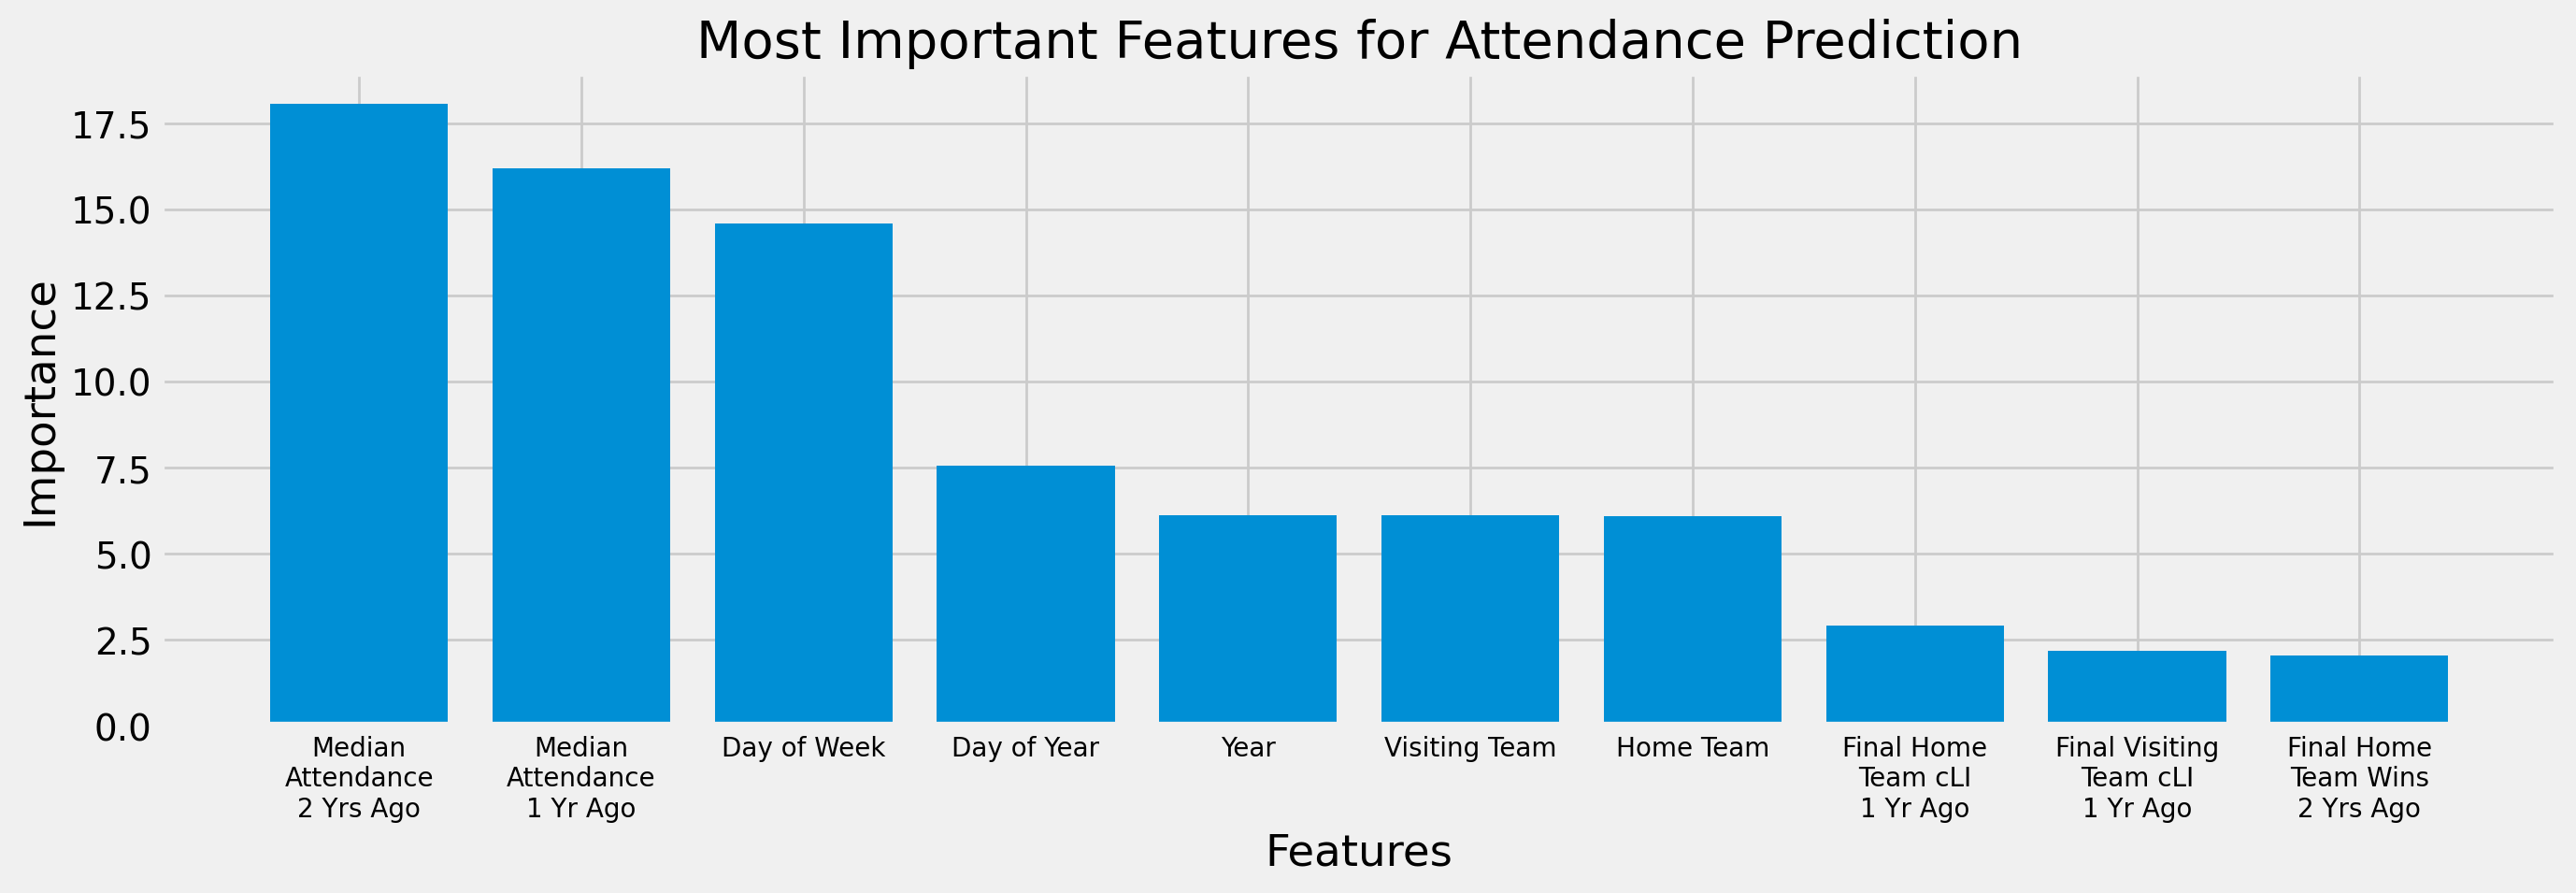

In [234]:
fig = plt.figure(figsize=(14, 5), tight_layout=True)
ax = fig.add_subplot(111)
ax.bar(x=important_features['features'], height=important_features['Importances'])
ax.tick_params(axis='x', labelsize=10)
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Most Important Features for Attendance Prediction')

Text(0, 0.5, 'Observed Attendance')

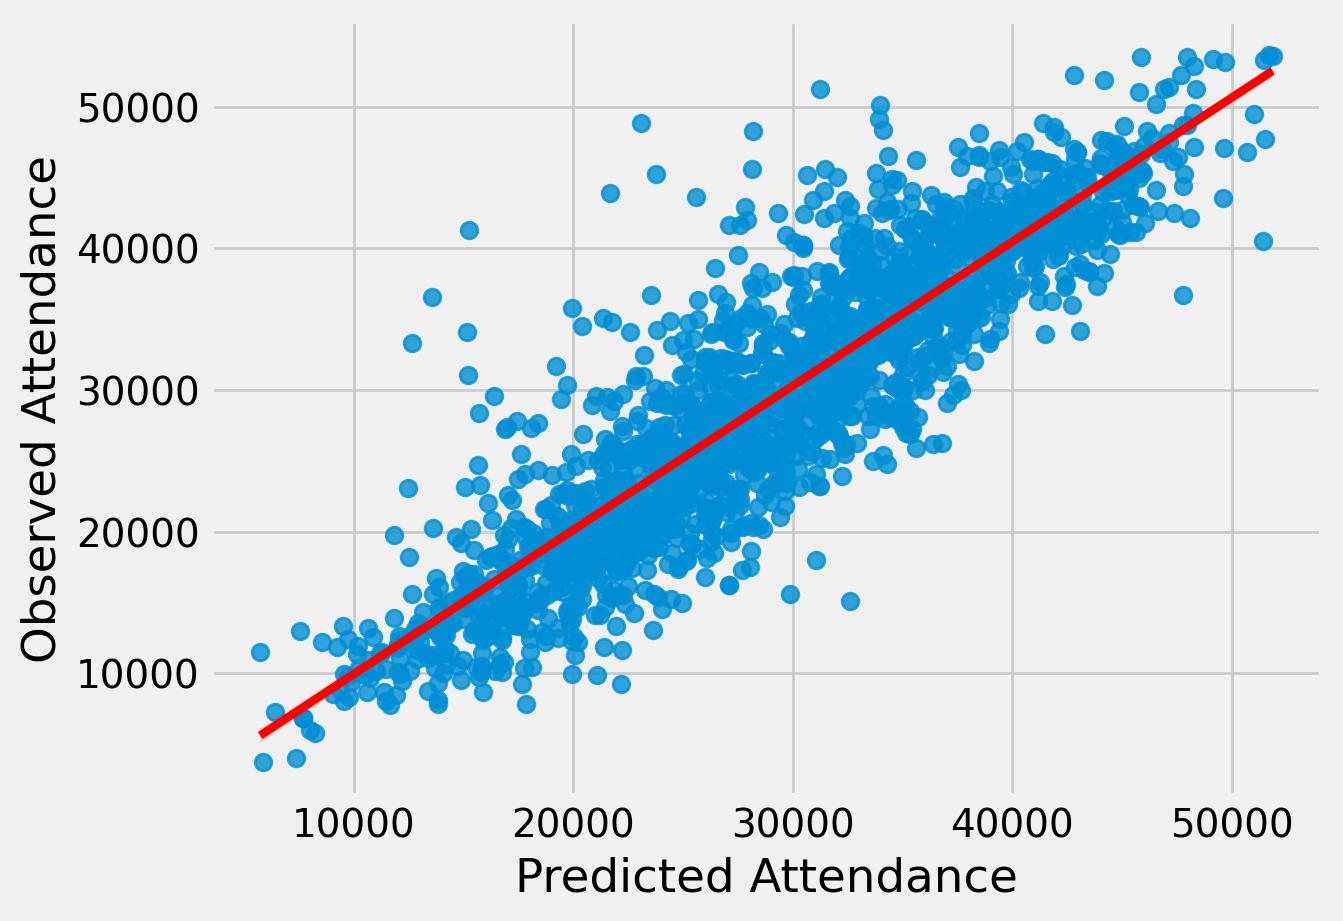

In [252]:
y_pred = reg.predict(X_test)
ax = sns.regplot(x=y_pred, y=y_test, line_kws=dict(color='r', linewidth=3))
ax.set_xlabel("Predicted Attendance")
ax.set_ylabel("Observed Attendance")